<a href="https://colab.research.google.com/github/4GeeksAcademy/Proyecto_Final_Close-Loop-Intelligence/blob/main/Proyecto_Final_Close_Loop_Intelligence_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Idea Integral Ganadora: Close Loop Intelligence
---

1. ***Definición del Problema (El "Pitch" de Negocio)***

    Muchas empresas sufren de dos males: el stockout (perder ventas por no tener producto) o el exceso de inventario (dinero muerto en estanterías que se deprecia). Este proyecto construye un Sistema de Inteligencia de Ciclo Cerrado que predice cuánto se va a vender para decidir exactamente cuánto comprar y qué promocionar para salir del inventario lento.

2. **Arquitectura de Datos (Paso 2 y 3: Ingesta y SQL)**

    Para llegar a las 60,000+ filas, utilizaremos un dataset transaccional histórico.

    Origen: Dataset de Retail (tipo Online Retail II o Instacart).

    Modelo de Datos (SQL): Almacenarás los datos en una base de datos relacional con este esquema:

        Tabla_Ventas: ID_Transaccion, Fecha, ID_Producto, Cantidad, Precio_Unitario, ID_Cliente.

        Tabla_Productos: ID_Producto, Categoria, Costo_Reposicion, Stock_Actual, Punto_Reorden.

    Uso de SQL (Crítico): No solo cargarás los datos. Usarás SQL para crear una Vista Maestra mediante un JOIN. Calcularás el "Lead Time" (tiempo de entrega) y la "Venta Promedio Diaria" usando GROUP BY y funciones agregadas. Esta vista será la que alimentará tu modelo de Machine Learning.

3. **El Cerebro del Proyecto (Paso 4, 5 y 6: EDA y ML)**

    Aquí es donde ocurre la magia. Dividiremos el modelo en dos enfoques:

    *Enfoque de Ventas (Predicción de Demanda):*

    Utilizarás un modelo de Series Temporales o Regresión (como Random Forest Regressor) para predecir cuántas unidades de un producto se venderán en los próximos 15-30 días basándote en la estacionalidad y tendencias históricas.

    *Enfoque de Compras/Inventario (Optimización):*

    Clasificación ABC: Usarás los datos para clasificar productos. Los "A" son los que más dinero generan (nunca pueden faltar), los "C" son los lentos.

    Cálculo de Stock de Seguridad: Aplicarás fórmulas estadísticas para determinar el inventario mínimo necesario.

4. **La Salida en Ventas: "Revenue Optimizer"**

    Para darle ese toque final de ventas que mencionaste, añadiremos un componente de Estrategia Comercial:

    Si el modelo predice una demanda baja para un producto con mucho stock (Exceso), la aplicación sugerirá automáticamente un descuento o promoción de "cross-selling" para forzar la salida de esa mercancía y recuperar flujo de caja.

    No podremos aplicar la estrategia de cross-selling dado que no contamos con stock en el modelo de datos.

5. **Desarrollo de la Web App (Paso 7: La interfaz)**
    
    La aplicación (en Streamlit) tendrá tres pestañas claras para el usuario final:

    *Dashboard Ejecutivo (Ventas):* Gráficos elocuentes que muestran la proyección de ingresos para el próximo mes y el "Top 10" de productos estrella.

    *Módulo de Compras (Reposición):* Una tabla generada por tu modelo que diga: "Debes pedir 500 unidades del Producto X hoy mismo al proveedor Y para no quedar desabastecido el lunes".

    *Módulo de Ofertas (Salida de Inventario):* Una sección que resalte: "¡Alerta! Tienes demasiado stock de este producto. Aplica un 15% de descuento para incentivar la venta". No podremos aplicar la estrategia del modulo de ofertas ya que no contamos con el dato de stock en el dataset.

In [2]:
#Realizamos la instalacion para ejecutar la conexion con Kaggle
!pip install kaggle
!pip install opendatasets

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import opendatasets as od
import sqlite3
import os
import glob

od.download('https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Rubeneduardoo
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce


100%|██████████| 42.6M/42.6M [00:00<00:00, 1.35GB/s]

In [4]:
#Configuramos Nombres de Base de Datos
BD = 'BaseSQL.db'
csv_files = glob.glob('brazilian-ecommerce/*.csv')

conexion = sqlite3.connect(BD)

try:
    print(f"Iniciando migración de {len(csv_files)} archivos a la base de datos...")

    for archivo in csv_files:
        # Limpiamos el nombre para la tabla (sin extensión y sin caracteres raros)
        nombre_tabla = os.path.splitext(archivo)[0].replace(" ", "_").lower()

        # Cargamos el archivo a un DataFrame
        df = pd.read_csv(archivo)

        # 3. Guardar en la base de datos
        # index=False evita que se cree una columna extra para el índice de pandas
        df.to_sql(nombre_tabla, conexion, if_exists='replace', index=False)

        print(f"Cargado con éxito: {archivo} -> Tabla: {nombre_tabla}")

    print("\nProceso finalizado. Ahora puedes borrar los .csv originales si lo deseas.")

finally:
    conexion.close()

Iniciando migración de 9 archivos a la base de datos...
Cargado con éxito: brazilian-ecommerce/olist_sellers_dataset.csv -> Tabla: brazilian-ecommerce/olist_sellers_dataset
Cargado con éxito: brazilian-ecommerce/product_category_name_translation.csv -> Tabla: brazilian-ecommerce/product_category_name_translation
Cargado con éxito: brazilian-ecommerce/olist_products_dataset.csv -> Tabla: brazilian-ecommerce/olist_products_dataset
Cargado con éxito: brazilian-ecommerce/olist_order_payments_dataset.csv -> Tabla: brazilian-ecommerce/olist_order_payments_dataset
Cargado con éxito: brazilian-ecommerce/olist_geolocation_dataset.csv -> Tabla: brazilian-ecommerce/olist_geolocation_dataset
Cargado con éxito: brazilian-ecommerce/olist_orders_dataset.csv -> Tabla: brazilian-ecommerce/olist_orders_dataset
Cargado con éxito: brazilian-ecommerce/olist_customers_dataset.csv -> Tabla: brazilian-ecommerce/olist_customers_dataset
Cargado con éxito: brazilian-ecommerce/olist_order_items_dataset.csv -> Tab

In [5]:
#Consulta SQL
conexion = sqlite3.connect(BD)
cursor = conexion.cursor()

cursor.execute('SELECT name FROM sqlite_master WHERE type = "table"')
tablas = cursor.fetchall()

for tabla in tablas:
    print(tabla[0])


brazilian-ecommerce/olist_sellers_dataset
brazilian-ecommerce/product_category_name_translation
brazilian-ecommerce/olist_products_dataset
brazilian-ecommerce/olist_order_payments_dataset
brazilian-ecommerce/olist_geolocation_dataset
brazilian-ecommerce/olist_orders_dataset
brazilian-ecommerce/olist_customers_dataset
brazilian-ecommerce/olist_order_items_dataset
brazilian-ecommerce/olist_order_reviews_dataset


In [6]:
# Consulta simple para listar todas las tablas
query = "SELECT name FROM sqlite_master WHERE type='table';"

# Ejecución
df_tablas = pd.read_sql_query(query, conexion)
print(df_tablas)

                                                name
0          brazilian-ecommerce/olist_sellers_dataset
1  brazilian-ecommerce/product_category_name_tran...
2         brazilian-ecommerce/olist_products_dataset
3   brazilian-ecommerce/olist_order_payments_dataset
4      brazilian-ecommerce/olist_geolocation_dataset
5           brazilian-ecommerce/olist_orders_dataset
6        brazilian-ecommerce/olist_customers_dataset
7      brazilian-ecommerce/olist_order_items_dataset
8    brazilian-ecommerce/olist_order_reviews_dataset


In [7]:
#Ejecutamos una consulta simple - DF Order Review

conn = sqlite3.connect(BD)
tables = ['order_reviews', 'products','orders','customers','sellers','order_items','geolocation','order_payments']
dfT = {}

for table in tables:
    query = f'SELECT * FROM "brazilian-ecommerce/olist_{table}_dataset" '
    dfT[table] = pd.read_sql_query(query, conn)
    print(f"Tabla '{table}' cargada con {len(dfT[table])} filas.")



Tabla 'order_reviews' cargada con 99224 filas.
Tabla 'products' cargada con 32951 filas.
Tabla 'orders' cargada con 99441 filas.
Tabla 'customers' cargada con 99441 filas.
Tabla 'sellers' cargada con 3095 filas.
Tabla 'order_items' cargada con 112650 filas.
Tabla 'geolocation' cargada con 1000163 filas.
Tabla 'order_payments' cargada con 103886 filas.


In [8]:
for t in tables:
  print(dfT[t].shape)

(99224, 7)
(32951, 9)
(99441, 8)
(99441, 5)
(3095, 4)
(112650, 7)
(1000163, 5)
(103886, 5)


In [9]:
dfT['customers'].head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [10]:
dfT['order_items'].head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [11]:
dfT['order_payments'].head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [12]:
dfT['orders'].head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [13]:
dfT['products'].head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [14]:
dfT['sellers'].head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [15]:
dfT['geolocation'].head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [16]:
dfT['order_reviews'].head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,None,None,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,None,None,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,None,None,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,None,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,None,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [17]:
#Prueba de Ejecucion del Master JOUN para las Tablas de Ventas

##Columnas de la primera transformacion para la tabla de ventas: Fecha, ID_Orden, ID_Cliente, ID_Producto, Posicon_Item, Precio_Unitario

query_maestra = """
SELECT
    o.order_purchase_timestamp AS Fecha,
    o.order_id AS ID_Orden,
    o.customer_id AS ID_Cliente,
    i.product_id AS ID_Producto,
    i.order_item_id AS Posicion_Item,
    i.price AS Precio_Unitario,
    i.price AS Precio_Unitario,
    i.freight_value AS Costo_Flete,
    pay.payment_value AS Total_Pago_Orden
FROM "brazilian-ecommerce/olist_orders_dataset" o
JOIN "brazilian-ecommerce/olist_order_items_dataset" i ON o.order_id = i.order_id
JOIN "brazilian-ecommerce/olist_order_payments_dataset" pay ON o.order_id = pay.order_id
LIMIT 1000;
"""

df_ventas = pd.read_sql_query(query_maestra, conn)
display(df_ventas.head())

#Cabe destacar que este DF de Ventas aun no contempla cantidad de items vendidos dentro de una orden. Por tanto, se requieren mas transformaciones

,Fecha,ID_Orden,ID_Cliente,ID_Producto,Posicion_Item,Precio_Unitario,Precio_Unitario,Costo_Flete,Total_Pago_Orden
0,2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,87285b34884572647811a353c7ac498a,1,29.99,29.99,8.72,2.00
1,2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,87285b34884572647811a353c7ac498a,1,29.99,29.99,8.72,18.12
2,2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,87285b34884572647811a353c7ac498a,1,29.99,29.99,8.72,18.59
3,2018-07-24 20:41:37,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,595fac2a385ac33a80bd5114aec74eb8,1,118.70,118.70,22.76,141.46
4,2018-08-08 08:38:49,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,aa4383b373c6aca5d8797843e5594415,1,159.90,159.90,19.22,179.12


In [18]:
# Calculamos la cantidad de productos, el Subtotal de la Orden, y el Total de la Misma

queryV = """
  SELECT
    o.order_id,
    i.product_id,
    i.price AS Precio_Unitario,
    COUNT(i.product_id) AS Cantidad_Productos,
    COUNT(i.product_id) * i.price AS Subtotal_Orden,
    i.freight_value AS Costo_Flete,
    (COUNT(i.product_id) * i.price) + i.freight_value AS Total_Orden,
    SUM(pay.payment_value) AS Total_Pago_Orden

  FROM "brazilian-ecommerce/olist_orders_dataset" o
  JOIN "brazilian-ecommerce/olist_order_items_dataset" i ON o.order_id = i.order_id
  JOIN "brazilian-ecommerce/olist_order_payments_dataset" pay ON o.order_id = pay.order_id
  GROUP BY o.order_id;
    """

consultaV = pd.read_sql_query(queryV, conn)
consultaV.sort_values(by='Cantidad_Productos', ascending=False).head()

,order_id,product_id,Precio_Unitario,Cantidad_Productos,Subtotal_Orden,Costo_Flete,Total_Orden,Total_Pago_Orden
52745,895ab968e7bb0d5659d16cd74cd1650c,5ddab10d5e0a23acb99acf56b62b3276,83.80,63,5279.40,5.12,5284.52,483.96
98246,fedcd9f7ccdc8cba3a18defedd1a5547,0554911df28fda9fd668ce5ba5949695,79.99,38,3039.62,22.88,3062.50,411.48
96501,fa65dad1b0e818e3ccc5cb0e39231352,1aecdb5fa3add74e385f25c6c527a462,392.55,29,11383.95,65.44,11449.39,457.99
78975,ccf804e764ed5650cd8759557269dc13,8d37ee446981d3790967d0268d6cfc81,49.99,26,1299.74,12.69,1312.43,62.68
76421,c6492b842ac190db807c15aff21a7dd6,0449db5eede617c5fd413071d582f038,189.90,24,4557.60,22.80,4580.40,850.80


In [19]:
# Averiguamos la cantidad de pagos que se

pago_q = """
  SELECT
    pay.order_id,
    SUM(pay.payment_value) AS Total_Pago_Orden,
    COUNT(pay.payment_type) AS Cantidad_Pagos
  FROM "brazilian-ecommerce/olist_order_payments_dataset" pay
  GROUP BY pay.order_id;
"""

consulta_pago = pd.read_sql_query(pago_q, conn)
consulta_pago.sort_values(by='Total_Pago_Orden', ascending=False).head()


,order_id,Total_Pago_Orden,Cantidad_Pagos
1471,03caa2c082116e1d31e67e9ae3700499,13664.08,1
44830,736e1922ae60d0d6a89247b851902527,7274.88,1
3156,0812eb902a67711a1cb742b3cdaa65ae,6929.31,1
99071,fefacc66af859508bf1a7934eab1e97f,6922.21,1
95186,f5136e38d1a14a4dbd87dff67da82701,6726.66,1


In [20]:
pagosdf = pd.DataFrame(consulta_pago)
pagosdf[pagosdf['order_id'] == '0008288aa423d2a3f00fcb17cd7d8719']

,order_id,Total_Pago_Orden,Cantidad_Pagos
13,0008288aa423d2a3f00fcb17cd7d8719,126.54,1


In [21]:
r = pd.DataFrame(consultaV)
r.loc[r['order_id'] == '03caa2c082116e1d31e67e9ae3700499']

,order_id,product_id,Precio_Unitario,Cantidad_Productos,Subtotal_Orden,Costo_Flete,Total_Orden,Total_Pago_Orden
1455,03caa2c082116e1d31e67e9ae3700499,5769ef0a239114ac3a854af00df129e4,1680.0,8,13440.0,28.01,13468.01,109312.64


In [22]:
#Rehacemos el query final para la obtencion del DataFrame de Ventas

query_final = """
  WITH Total_Pagos AS (
    SELECT
      pay.order_id,
      SUM(pay.payment_value) AS Total_Pago_Orden
    FROM "brazilian-ecommerce/olist_order_payments_dataset" pay
    GROUP BY pay.order_id
  )
SELECT
    o.order_purchase_timestamp AS "Fecha",
    o.order_id AS "Orden ID",
    o.customer_id AS "Cliente ID",
    c.customer_unique_id AS "Nombre del Cliente",
    c.customer_city AS "Ciudad Cliente",
    s.seller_id AS "Vendedor ID",
    s.seller_city AS "Ciudad Vendedor",
    i.product_id AS "Producto ID",
    p.product_category_name AS "Categoria Producto",
    p.product_weight_g AS "Peso Producto",
    p.product_length_cm AS "Longitud Producto",
    p.product_height_cm AS "Altura Producto",
    p.product_width_cm AS "Ancho Producto",
    p.product_photos_qty AS "Cantidad Fotos Producto",
    i.price AS "Precio Unitario",
    COUNT(i.product_id) AS "Cantidad",
    COUNT(i.product_id) * i.price AS "Subtotal Orden",
    i.freight_value AS "Costo Flete",
    (COUNT(i.product_id) * i.price) + i.freight_value AS "Total Orden",
    SUM(pay.payment_value) AS "Total Pago Orden",
    (o.order_purchase_timestamp - order_estimated_delivery_date) AS "Tiempo Entrega Estimado",
    o.order_status AS "Estado Orden",
    r.review_score AS "Calificacion"


  FROM "brazilian-ecommerce/olist_orders_dataset" o
  JOIN "brazilian-ecommerce/olist_order_items_dataset" i ON o.order_id = i.order_id
  JOIN "brazilian-ecommerce/olist_order_payments_dataset" pay ON o.order_id = pay.order_id
  JOIN "brazilian-ecommerce/olist_customers_dataset" c ON o.customer_id = c.customer_id -- Agregamos el join para la tabla de clientes
  JOIN "brazilian-ecommerce/olist_sellers_dataset" s ON i.seller_id = s.seller_id
  JOIN "brazilian-ecommerce/olist_products_dataset" p ON i.product_id = p.product_id
  LEFT JOIN "brazilian-ecommerce/olist_order_reviews_dataset" r ON o.order_id = r.order_id
  GROUP BY o.order_id; -- Es posible que necesitemos ajustar el GROUP BY más adelante.
  """

Ventas_DF = pd.read_sql_query(query_final, conn)
Ventas_DF.sort_values(by='Cantidad', ascending=False).head()

,Fecha,Orden ID,Cliente ID,Nombre del Cliente,Ciudad Cliente,Vendedor ID,Ciudad Vendedor,Producto ID,Categoria Producto,Peso Producto,...,Cantidad Fotos Producto,Precio Unitario,Cantidad,Subtotal Orden,Costo Flete,Total Orden,Total Pago Orden,Tiempo Entrega Estimado,Estado Orden,Calificacion
52745,2017-08-08 20:26:31,895ab968e7bb0d5659d16cd74cd1650c,270c23a11d024a44c896d1894b261a83,9a736b248f67d166d2fbb006bcb877c3,sao paulo,3d0cd21d41671c46f82cd11176bf7277,joinville,5ddab10d5e0a23acb99acf56b62b3276,utilidades_domesticas,450.0,...,8.0,83.80,63,5279.40,5.12,5284.52,483.96,0,delivered,5.0
98246,2017-09-23 14:56:45,fedcd9f7ccdc8cba3a18defedd1a5547,13aa59158da63ba0e93ec6ac2c07aacb,6fbc7cdadbb522125f4b27ae9dee4060,rio de janeiro,7c67e1448b00f6e969d365cea6b010ab,itaquaquecetuba,0554911df28fda9fd668ce5ba5949695,moveis_escritorio,5200.0,...,1.0,79.99,38,3039.62,22.88,3062.50,411.48,0,delivered,5.0
96501,2017-04-20 12:45:34,fa65dad1b0e818e3ccc5cb0e39231352,9af2372a1e49340278e7c1ef8d749f34,8af7ac63b2efbcbd88e5b11505e8098a,cuiaba,06532f10282704ef4c69168b914b77be,paincandu,1aecdb5fa3add74e385f25c6c527a462,ferramentas_jardim,16400.0,...,1.0,392.55,29,11383.95,65.44,11449.39,457.99,0,shipped,1.0
78975,2017-06-07 12:05:10,ccf804e764ed5650cd8759557269dc13,92cd3ec6e2d643d4ebd0e3d6238f69e2,569aa12b73b5f7edeaa6f2a01603e381,sao paulo,1900267e848ceeba8fa32d80c1a5f5a8,ibitinga,8d37ee446981d3790967d0268d6cfc81,cama_mesa_banho,1100.0,...,1.0,49.99,26,1299.74,12.69,1312.43,62.68,0,delivered,5.0
40301,2017-07-07 14:55:43,68986e4324f6a21481df4e6e89abcf01,86cc80fef09f7f39df4b0dbce48e81cb,db1af3fd6b23ac3873ef02619d548f9c,itaqui,dbc22125167c298ef99da25668e1011f,borda da mata,2b939dc9b176d7fa21594d588815d4a4,malas_acessorios,1300.0,...,1.0,102.90,24,2469.60,8.73,2478.33,658.44,0,delivered,1.0


In [23]:
n = pd.DataFrame(Ventas_DF)
n.loc[n['Orden ID'] == '03caa2c082116e1d31e67e9ae3700499' ]


,Fecha,Orden ID,Cliente ID,Nombre del Cliente,Ciudad Cliente,Vendedor ID,Ciudad Vendedor,Producto ID,Categoria Producto,Peso Producto,...,Cantidad Fotos Producto,Precio Unitario,Cantidad,Subtotal Orden,Costo Flete,Total Orden,Total Pago Orden,Tiempo Entrega Estimado,Estado Orden,Calificacion
1455,2017-09-29 15:24:52,03caa2c082116e1d31e67e9ae3700499,1617b1357756262bfa56ab541c47bc16,0a0a92112bd4c708ca5fde585afaa872,rio de janeiro,b37c4c02bda3161a7546a4e6d222d5b2,sao paulo,5769ef0a239114ac3a854af00df129e4,telefonia_fixa,750.0,...,3.0,1680.0,8,13440.0,28.01,13468.01,109312.64,0,delivered,1.0


In [24]:
n.shape

(98665, 23)

In [25]:
pagosdf[pagosdf['order_id'] == '016726239765c18f66826453f39c64e3']

,order_id,Total_Pago_Orden,Cantidad_Pagos
533,016726239765c18f66826453f39c64e3,265.77,1


In [26]:
n.loc[n['Orden ID']== '016726239765c18f66826453f39c64e3']

,Fecha,Orden ID,Cliente ID,Nombre del Cliente,Ciudad Cliente,Vendedor ID,Ciudad Vendedor,Producto ID,Categoria Producto,Peso Producto,...,Cantidad Fotos Producto,Precio Unitario,Cantidad,Subtotal Orden,Costo Flete,Total Orden,Total Pago Orden,Tiempo Entrega Estimado,Estado Orden,Calificacion
525,2017-06-14 09:16:44,016726239765c18f66826453f39c64e3,6204061101097bad0b25b3c4fce9ee8d,6724236615afbc343645dacfa693fae0,sao paulo,37be5a7c751166fbc5f8ccba4119e043,sao paulo,c6ea63369936552872ae890c82175b4b,cama_mesa_banho,2900.0,...,4.0,219.99,1,219.99,15.14,235.13,265.77,0,delivered,5.0


In [27]:


n['Diferencia de Pago'] = n['Total Pago Orden'] - n['Total Orden']
n.loc[n['Diferencia de Pago'] > 10].sort_values(by='Cantidad', ascending=False)

,Fecha,Orden ID,Cliente ID,Nombre del Cliente,Ciudad Cliente,Vendedor ID,Ciudad Vendedor,Producto ID,Categoria Producto,Peso Producto,...,Precio Unitario,Cantidad,Subtotal Orden,Costo Flete,Total Orden,Total Pago Orden,Tiempo Entrega Estimado,Estado Orden,Calificacion,Diferencia de Pago
62660,2018-05-12 12:28:58,a3725dfe487d359b5be08cac48b64ec5,d22f25a9fadfb1abbc2e29395b1239f4,5419a7c9b86a43d8140e2939cd2c2f7e,sinop,9f505651f4a6abe901a56cdc21508025,sao paulo,4e53a453045707bbc5febcf5f32097ac,informatica_acessorios,250.0,...,14.99,24,359.76,22.06,381.82,1333.80,0,delivered,3.0,951.98
34716,2017-10-17 13:06:29,5a3b1c29a49756e75f1ef513383c0c12,be1c4e52bb71e0c54b11a26b8e8d59f2,d97b3cfb22b0d6b25ac9ed4e9c2d481b,sao paulo,d2374cbcbb3ca4ab1086534108cc3ab7,ibitinga,17d8b8e9c21ec0fc5b33724e32fe422e,cama_mesa_banho,1000.0,...,58.90,22,1295.80,2.66,1298.46,18786.90,0,delivered,1.0,17488.44
10831,2018-01-27 11:28:32,1c11d0f4353b31ac3417fbfa5f0f2a8a,50920f8cd0681fd86ebe93670c8fe52e,41a3b256cc497dc952a815b848345cbc,ijui,c7fdb77fdbff3c41981bc52f787e959e,santo andre,61b6e5d2e3ee58d2b341b8ef1a652b26,cama_mesa_banho,750.0,...,56.00,21,1176.00,12.77,1188.77,2951.83,0,delivered,1.0,1763.06
50137,2017-07-16 18:19:25,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,4546caea018ad8c692964e3382debd19,sao paulo,2709af9587499e95e803a6498a5a56e9,sao paulo,05b515fdc76e888aada3c6d66c201dff,beleza_saude,800.0,...,1.20,21,25.20,7.89,33.09,4118.31,0,delivered,1.0,4085.22
65715,2017-08-23 09:22:34,ab14fdcfbe524636d65ee38360e22ce8,bd5d39761aa56689a265d95d8d32b8be,698e1cf81d01a3d389d96145f7fa6df8,goiania,ce27a3cc3c8cc1ea79d11e561e9bebb6,sao paulo,9571759451b1d780ee7c15012ea109d4,automotivo,1400.0,...,98.70,20,1974.00,14.44,1988.44,45256.00,0,delivered,NaN,43267.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8257,2017-08-08 13:44:39,156ba06ab4556cd19613dca1cefa9f7a,cb196971e6f67237a41f2fe6235bbaf4,ed0ab782b03b402c0cafde88067ff9d2,mineiros,4e922959ae960d389249c378d1c939f5,jacarei,7b25acee1c4b91200a7e8e31bb977a06,utilidades_domesticas,1675.0,...,69.90,1,69.90,17.74,87.64,101.22,0,delivered,4.0,13.58
6474,2018-02-20 01:39:23,10a6730b0b333e2b017dd139a0530f19,ec9941bfae382794f75c237d60273a42,d747d5d50ec718b9ce0c27d8b44cd617,palmares,2e90cb1677d35cfe24eef47d441b7c87,sao paulo,93c902b021a9e594f658ab1b0351602a,eletronicos,1250.0,...,97.90,1,97.90,29.09,126.99,143.53,0,delivered,3.0,16.54
2374,2017-04-21 13:18:31,061c97a9bd7911f9d2031e1b820c344f,ddc1e728d2de6666c8a01a42901d36c3,e411f7646017f3ade17f5db10505736b,junqueiropolis,522620dcb18a6b31cd7bdf73665113a9,cascavel,a70f58bd49225ad1d9f199d3766385a8,informatica_acessorios,500.0,...,299.00,1,299.00,16.26,315.26,329.80,0,delivered,5.0,14.54
1123,2018-05-29 16:04:49,02f4dd90ba0feb8ec394cac05862d2b5,df6d93efba53a613bf2365f7945febb0,9484cca8fd716e613bc1a0bb17ed0172,humaita,e0eabded302882513ced4ea3eb0c7059,campinas,f3c62fde9d2e2acf6c7c46648571c070,consoles_games,150.0,...,79.90,1,79.90,51.06,130.96,141.65,0,delivered,5.0,10.69


In [28]:
#Rehacemos nuevamente el query final para la obtencion del DataFrame de Ventas

query_final = """
  WITH Total_Pagos AS (
    SELECT
      pay.order_id,
      SUM(pay.payment_value) AS Total_Pago_Orden
    FROM "brazilian-ecommerce/olist_order_payments_dataset" pay
    GROUP BY pay.order_id
  )
SELECT
    o.order_purchase_timestamp AS "Fecha",
    o.order_id AS "Orden ID",
    o.customer_id AS "Cliente ID",
    c.customer_unique_id AS "Nombre del Cliente",
    c.customer_state AS "Ciudad Cliente",
    s.seller_id AS "Vendedor ID",
    s.seller_city AS "Ciudad Vendedor",
    i.product_id AS "Producto ID",
    p.product_category_name AS "Categoria Producto",
    p.product_weight_g AS "Peso Producto g",
    (p.product_length_cm * p.product_height_cm * p.product_width_cm)  AS "Volumen Producto cm3",
    p.product_photos_qty AS "Fotos Producto",
    i.price AS "Precio Unitario",
    i.order_item_id AS "Cantidad",
    (i.order_item_id * i.price) AS "Subtotal Orden",
    i.freight_value AS "Costo Flete",
    (i.order_item_id * i.price) + i.freight_value AS "Total Orden",
    tp.Total_Pago_Orden AS "Total Pago Orden",
    (JULIANDAY(o.order_estimated_delivery_date) - JULIANDAY(o.order_purchase_timestamp)) AS "Tiempo Entrega Estimado (Dias)",
    o.order_status AS "Estado Orden",
    r.review_score AS "Calificacion"


  FROM "brazilian-ecommerce/olist_orders_dataset" o
  JOIN "brazilian-ecommerce/olist_order_items_dataset" i ON o.order_id = i.order_id
  JOIN "brazilian-ecommerce/olist_order_payments_dataset" pay ON o.order_id = pay.order_id
  JOIN "brazilian-ecommerce/olist_customers_dataset" c ON o.customer_id = c.customer_id
  JOIN "brazilian-ecommerce/olist_sellers_dataset" s ON i.seller_id = s.seller_id
  JOIN "brazilian-ecommerce/olist_products_dataset" p ON i.product_id = p.product_id
  LEFT JOIN "brazilian-ecommerce/olist_order_reviews_dataset" r ON o.order_id = r.order_id
  JOIN Total_Pagos tp ON o.order_id = tp.order_id
  GROUP BY o.order_id, i.product_id;
  """

Ventas_DF = pd.read_sql_query(query_final, conn)
Ventas_DF.sort_values(by='Cantidad', ascending=False).head()

,Fecha,Orden ID,Cliente ID,Nombre del Cliente,Ciudad Cliente,Vendedor ID,Ciudad Vendedor,Producto ID,Categoria Producto,Peso Producto g,...,Fotos Producto,Precio Unitario,Cantidad,Subtotal Orden,Costo Flete,Total Orden,Total Pago Orden,Tiempo Entrega Estimado (Dias),Estado Orden,Calificacion
52029,2017-07-16 18:19:25,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,4546caea018ad8c692964e3382debd19,SP,2709af9587499e95e803a6498a5a56e9,sao paulo,79ce45dbc2ea29b22b5a261bbb7b7ee7,beleza_saude,1000.0,...,2.0,7.8,21,163.8,6.57,170.37,196.11,11.236516,delivered,1.0
39714,2018-04-17 21:08:59,637617b3ffe9e2f7a2411243829226d0,daf15f1b940cc6a72ba558f093dc00dd,37bc3d463e2a0024012a7fa587597a3c,SC,1f50f920176fa81dab994f9023523100,sao jose do rio preto,bf44071ef18f5c9ded039681c68b1996,bebes,6050.0,...,2.0,79.9,10,799.0,24.02,823.02,1246.97,29.118762,delivered,4.0
80870,2018-08-12 02:11:20,ca3625898fbd48669d50701aba51cd5f,0d861a5e4dd6a9079d89e1330848f0ab,c8ed31310fc440a3f8031b177f9842c3,SP,0b35c634521043bf4b47e21547b99ab5,teixeira soares,309dd69eb83cea38c51709d62befe1a4,construcao_ferramentas_construcao,2150.0,...,1.0,56.0,9,504.0,3.68,507.68,1157.28,31.908796,delivered,3.0
80869,2018-08-12 02:11:20,ca3625898fbd48669d50701aba51cd5f,0d861a5e4dd6a9079d89e1330848f0ab,c8ed31310fc440a3f8031b177f9842c3,SP,0b35c634521043bf4b47e21547b99ab5,teixeira soares,21b524c4c060169fa75ccf08c7da4627,construcao_ferramentas_construcao,3350.0,...,1.0,63.7,8,509.6,0.15,509.75,1157.28,31.908796,delivered,3.0
36029,2017-10-17 13:06:29,5a3b1c29a49756e75f1ef513383c0c12,be1c4e52bb71e0c54b11a26b8e8d59f2,d97b3cfb22b0d6b25ac9ed4e9c2d481b,SP,d2374cbcbb3ca4ab1086534108cc3ab7,ibitinga,e95fb3a80ca294f39de925b6428f3a32,cama_mesa_banho,1300.0,...,1.0,78.9,8,631.2,7.98,639.18,853.95,16.453831,delivered,1.0


In [29]:
Ventas_DF.shape

(102424, 21)

In [30]:
# Creamos la variable sintetica de Tiempo de Reposicion de un Producto basado en la categoria
categorias = list((Ventas_DF['Categoria Producto'].unique()))
np.random.seed(42)
lead_time_rep = {c: np.random.randint(1,91) for c in categorias}
lead_time_rep





{'cool_stuff': 52,
 'pet_shop': 15,
 'moveis_decoracao': 72,
 'perfumaria': 61,
 'ferramentas_jardim': 21,
 'utilidades_domesticas': 83,
 'telefonia': 87,
 'beleza_saude': 75,
 'livros_tecnicos': 75,
 'fashion_bolsas_e_acessorios': 88,
 'cama_mesa_banho': 24,
 'esporte_lazer': 3,
 'consoles_games': 22,
 'moveis_escritorio': 53,
 'malas_acessorios': 2,
 'alimentos': 88,
 'agro_industria_e_comercio': 30,
 'eletronicos': 38,
 'informatica_acessorios': 2,
 'construcao_ferramentas_construcao': 64,
 'audio': 60,
 'bebes': 21,
 'construcao_ferramentas_iluminacao': 33,
 'brinquedos': 76,
 'papelaria': 58,
 'industria_comercio_e_negocios': 22,
 'relogios_presentes': 89,
 'automotivo': 49,
 None: 59,
 'eletrodomesticos': 42,
 'moveis_cozinha_area_de_servico_jantar_e_jardim': 60,
 'climatizacao': 80,
 'casa_conforto': 15,
 'telefonia_fixa': 62,
 'portateis_casa_forno_e_cafe': 62,
 'fraldas_higiene': 47,
 'sinalizacao_e_seguranca': 62,
 'instrumentos_musicais': 51,
 'eletroportateis': 55,
 'constr

In [31]:
#Mapeamos el Tiempo de Reposicion por Categoria de Productos en el DF principal
Ventas_DF['Tiempo de Reposicion'] = Ventas_DF['Categoria Producto'].map(lead_time_rep)
display(Ventas_DF[['Producto ID', 'Categoria Producto', 'Tiempo de Reposicion']].head())


,Producto ID,Categoria Producto,Tiempo de Reposicion
0,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,52
1,e5f2d52b802189ee658865ca93d83a8f,pet_shop,15
2,c777355d18b72b67abbeef9df44fd0fd,moveis_decoracao,72
3,7634da152a4610f1595efa32f14722fc,perfumaria,61
4,ac6c3623068f30de03045865e4e10089,ferramentas_jardim,21


In [32]:
#Verificamos si tenemos valores nulos
Ventas_DF.isnull().sum()

,0
Fecha,0
Orden ID,0
Cliente ID,0
Nombre del Cliente,0
Ciudad Cliente,0
Vendedor ID,0
Ciudad Vendedor,0
Producto ID,0
Categoria Producto,1460
Peso Producto g,16


In [33]:
t = Ventas_DF.loc[Ventas_DF['Categoria Producto'].isnull()]
t[['Categoria Producto','Tiempo de Reposicion']]

,Categoria Producto,Tiempo de Reposicion
113,None,59
115,None,59
122,None,59
128,None,59
154,None,59
...,...,...
102103,None,59
102129,None,59
102145,None,59
102230,None,59


In [34]:
Ventas_DF.dropna(inplace=True)

In [35]:
Ventas_DF.isnull().sum()

,0
Fecha,0
Orden ID,0
Cliente ID,0
Nombre del Cliente,0
Ciudad Cliente,0
Vendedor ID,0
Ciudad Vendedor,0
Producto ID,0
Categoria Producto,0
Peso Producto g,0


In [36]:
#Calculo del Stock Minimo Estadistico
products = Ventas_DF.groupby('Producto ID').agg(
    Cantidad_Media = ('Cantidad', 'mean'),
    Cantidad_Desviacion = ('Cantidad', 'std'),
    Tiempo_de_Reposicion = ('Tiempo de Reposicion', 'first')
).reset_index()

products.head()

,Producto ID,Cantidad_Media,Cantidad_Desviacion,Tiempo_de_Reposicion
0,00066f42aeeb9f3007548bb9d3f33c38,1.0,NaN,61
1,00088930e925c41fd95ebfe695fd2655,1.0,NaN,49
2,0009406fd7479715e4bef61dd91f2462,1.0,NaN,24
3,000b8f95fcb9e0096488278317764d19,1.0,0.0,83
4,000d9be29b5207b54e86aa1b1ac54872,1.0,NaN,89


In [37]:
products['Cantidad_Desviacion'].fillna(0, inplace=True)
products.head()

/tmp/ipython-input-716955406.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  products['Cantidad_Desviacion'].fillna(0, inplace=True)


,Producto ID,Cantidad_Media,Cantidad_Desviacion,Tiempo_de_Reposicion
0,00066f42aeeb9f3007548bb9d3f33c38,1.0,0.0,61
1,00088930e925c41fd95ebfe695fd2655,1.0,0.0,49
2,0009406fd7479715e4bef61dd91f2462,1.0,0.0,24
3,000b8f95fcb9e0096488278317764d19,1.0,0.0,83
4,000d9be29b5207b54e86aa1b1ac54872,1.0,0.0,89


In [38]:
# Definicion de Stock Minimo, Stock de Seguridad y Parametros Asociados:

# Nivel de Servicio o Intervalos de Confianza (Logistica Avanzada)
Z_dict = {
    'A': 2.33, #Producto de Alta Rotacion 99% de Confianza
    'B': 1.645, #Producto de Media Rotacion 95% de Confianza
    'C': 1.282   #Producto de Baja Rotacion 80% de Confianza
}


# Se iniciara el calculo del Stock Minimo con un intervalo de Confianza estandar de 95% para luego ajustarlo segun sea la Clasificacion del Producto con Z_dict

#Stock de Seguridad y Stock Minimo
z = Z_dict['B']
products['Stock de Seguridad'] = z * products['Cantidad_Desviacion']* np.sqrt(products['Tiempo_de_Reposicion'])
products['Stock Minimo'] = (products['Cantidad_Media']* products['Tiempo_de_Reposicion']) + products['Stock de Seguridad']

products.sort_values('Cantidad_Media', ascending= False).head()



,Producto ID,Cantidad_Media,Cantidad_Desviacion,Tiempo_de_Reposicion,Stock de Seguridad,Stock Minimo
15440,79ce45dbc2ea29b22b5a261bbb7b7ee7,21.0,0.0,75,0.0,1575.0
24010,bf44071ef18f5c9ded039681c68b1996,10.0,0.0,21,0.0,210.0
26247,d05bb6074b45c20f7a516c239c0a1c43,7.0,0.0,15,0.0,105.0
12330,61b6e5d2e3ee58d2b341b8ef1a652b26,7.0,0.0,24,0.0,168.0
26490,d25bbb182b51d1594fe3b54a27ae143e,7.0,0.0,24,0.0,168.0


In [39]:
products.shape

(32183, 6)

In [40]:
#Clasificacion de Producto por Volumen de Ventas en Cantidad basado en el pareto de las ventas

products = products.sort_values('Cantidad_Media', ascending=False)

#Porcentaje Acumulado sobre el total de unidades vendidas
unidades_vendidas = products['Cantidad_Media'].sum()
products['Porcentaje Acumulado'] = products['Cantidad_Media'].cumsum() / unidades_vendidas

#Definicion de la funcion de ClasificacionABC A: Alta Rotacion, B: Rotacion Media, C: Baja Rotacion
def ClasificacionABC(PorcentajeAcumulado):
    """
    Asigna la categoria de rotacion basada en el porcentaje acumulado por unidades vendidas.
    """
    if PorcentajeAcumulado <= 0.8:
        return 'A'
    elif PorcentajeAcumulado <= 0.95:
        return 'B'
    else:
        return 'C'

#ClasificacionABC (Variable Objetivo)
products['ClasificacionABC'] = products['Porcentaje Acumulado'].apply(ClasificacionABC)

products.head()

,Producto ID,Cantidad_Media,Cantidad_Desviacion,Tiempo_de_Reposicion,Stock de Seguridad,Stock Minimo,Porcentaje Acumulado,ClasificacionABC
15440,79ce45dbc2ea29b22b5a261bbb7b7ee7,21.0,0.0,75,0.0,1575.0,0.000613,A
24010,bf44071ef18f5c9ded039681c68b1996,10.0,0.0,21,0.0,210.0,0.000905,A
26247,d05bb6074b45c20f7a516c239c0a1c43,7.0,0.0,15,0.0,105.0,0.001110,A
12330,61b6e5d2e3ee58d2b341b8ef1a652b26,7.0,0.0,24,0.0,168.0,0.001314,A
26490,d25bbb182b51d1594fe3b54a27ae143e,7.0,0.0,24,0.0,168.0,0.001519,A


In [41]:
print(products['ClasificacionABC'].value_counts())

ClasificacionABC
A    25334
B     5136
C     1713
Name: count, dtype: int64


# Products es el DataFrame Final para el Modelo de Clasificacion de Rotacion de Inventario.

In [42]:
products

,Producto ID,Cantidad_Media,Cantidad_Desviacion,Tiempo_de_Reposicion,Stock de Seguridad,Stock Minimo,Porcentaje Acumulado,ClasificacionABC
15440,79ce45dbc2ea29b22b5a261bbb7b7ee7,21.0,0.0,75,0.0,1575.0,0.000613,A
24010,bf44071ef18f5c9ded039681c68b1996,10.0,0.0,21,0.0,210.0,0.000905,A
26247,d05bb6074b45c20f7a516c239c0a1c43,7.0,0.0,15,0.0,105.0,0.001110,A
12330,61b6e5d2e3ee58d2b341b8ef1a652b26,7.0,0.0,24,0.0,168.0,0.001314,A
26490,d25bbb182b51d1594fe3b54a27ae143e,7.0,0.0,24,0.0,168.0,0.001519,A
...,...,...,...,...,...,...,...,...
11234,58b81e95d79fc90308246d12ef1e2688,1.0,0.0,2,0.0,2.0,0.999883,C
11233,58b566d4cc7237145b29b21e9699e15c,1.0,0.0,2,0.0,2.0,0.999912,C
11232,58b365b0859f884f4d07490d902af193,1.0,0.0,72,0.0,72.0,0.999942,C
11231,58b0b0b3e6b7f8ecd3874db9c141250d,1.0,0.0,76,0.0,76.0,0.999971,C


In [43]:
A = products.loc[products['ClasificacionABC']=='A']
A


,Producto ID,Cantidad_Media,Cantidad_Desviacion,Tiempo_de_Reposicion,Stock de Seguridad,Stock Minimo,Porcentaje Acumulado,ClasificacionABC
15440,79ce45dbc2ea29b22b5a261bbb7b7ee7,21.0,0.0,75,0.0,1575.0,0.000613,A
24010,bf44071ef18f5c9ded039681c68b1996,10.0,0.0,21,0.0,210.0,0.000905,A
26247,d05bb6074b45c20f7a516c239c0a1c43,7.0,0.0,15,0.0,105.0,0.001110,A
12330,61b6e5d2e3ee58d2b341b8ef1a652b26,7.0,0.0,24,0.0,168.0,0.001314,A
26490,d25bbb182b51d1594fe3b54a27ae143e,7.0,0.0,24,0.0,168.0,0.001519,A
...,...,...,...,...,...,...,...,...
14240,70b98d329c7a32c6aaa4f6e13a12ddf6,1.0,0.0,21,0.0,21.0,0.799873,A
14254,70cbbf603be04fd0947d83608b9a2266,1.0,0.0,87,0.0,87.0,0.799902,A
14253,70c9d38055bb316285aa937715c2e82d,1.0,0.0,83,0.0,83.0,0.799931,A
14252,70c9ac8c8391f7aaf375c752eb40d265,1.0,0.0,76,0.0,76.0,0.799960,A


## Reestructuracion de Ventas_DF desde el Master JOIN para adaptar la estructura a una serie de tiempo.

In [44]:
Ventas_DF.head()

,Fecha,Orden ID,Cliente ID,Nombre del Cliente,Ciudad Cliente,Vendedor ID,Ciudad Vendedor,Producto ID,Categoria Producto,Peso Producto g,...,Precio Unitario,Cantidad,Subtotal Orden,Costo Flete,Total Orden,Total Pago Orden,Tiempo Entrega Estimado (Dias),Estado Orden,Calificacion,Tiempo de Reposicion
0,2017-09-13 08:59:02,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,RJ,48436dade18ac8b2bce089ec2a041202,volta redonda,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,650.0,...,58.90,1,58.90,13.29,72.19,72.19,15.625671,delivered,5.0,52
1,2017-04-26 10:53:06,00018f77f2f0320c557190d7a144bdd3,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,SP,dd7ddc04e1b6c2c614352b383efe2d36,sao paulo,e5f2d52b802189ee658865ca93d83a8f,pet_shop,30000.0,...,239.90,1,239.90,19.93,259.83,259.83,18.546458,delivered,4.0,15
2,2018-01-14 14:33:31,000229ec398224ef6ca0657da4fc703e,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,MG,5b51032eddd242adc84c38acab88f23d,borda da mata,c777355d18b72b67abbeef9df44fd0fd,moveis_decoracao,3050.0,...,199.00,1,199.00,17.87,216.87,216.87,21.393391,delivered,5.0,72
3,2018-08-08 10:00:35,00024acbcdf0a6daa1e931b038114c75,d4eb9395c8c0431ee92fce09860c5a06,af861d436cfc08b2c2ddefd0ba074622,SP,9d7a1d34a5052409006425275ba1c2b4,franca,7634da152a4610f1595efa32f14722fc,perfumaria,200.0,...,12.99,1,12.99,12.79,25.78,25.78,11.582928,delivered,4.0,61
4,2017-02-04 13:57:51,00042b26cf59d7ce69dfabb4e55b4fd9,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,SP,df560393f3a51e74553ab94004ba5c87,loanda,ac6c3623068f30de03045865e4e10089,ferramentas_jardim,3750.0,...,199.90,1,199.90,18.14,218.04,218.04,40.418160,delivered,5.0,21


In [45]:
Ventas_DF['Estado Orden'].unique()

array(['delivered', 'shipped', 'canceled', 'invoiced', 'processing',
       'approved', 'unavailable'], dtype=object)

In [46]:
Ventas_DF = Ventas_DF.loc[Ventas_DF['Estado Orden'] != 'canceled']
Ventas_DF.shape

(99744, 22)

In [47]:
Ventas_DF['Producto ID'].nunique()

31982

In [48]:
Ventas_DF['Categoria Producto'].nunique()

73

## Realizaremos un Merge entre Ventas_DF y Products para empezar a Segmentar las Ventas en Importancia de Rotacion y Categoria, adaptandonos a la estructura requerida para predecir correctamente en series de tiempo.

In [49]:
#1. Merge Estrategico
MasterVentas = Ventas_DF.merge(products[['Producto ID', 'ClasificacionABC']], on='Producto ID', how='inner')
MasterVentas.head()

#Optimizacion de Memoria
MasterVentas['ClasificacionABC'] = MasterVentas['ClasificacionABC'].astype('category')
MasterVentas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99744 entries, 0 to 99743
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   Fecha                           99744 non-null  object  
 1   Orden ID                        99744 non-null  object  
 2   Cliente ID                      99744 non-null  object  
 3   Nombre del Cliente              99744 non-null  object  
 4   Ciudad Cliente                  99744 non-null  object  
 5   Vendedor ID                     99744 non-null  object  
 6   Ciudad Vendedor                 99744 non-null  object  
 7   Producto ID                     99744 non-null  object  
 8   Categoria Producto              99744 non-null  object  
 9   Peso Producto g                 99744 non-null  float64 
 10  Volumen Producto cm3            99744 non-null  float64 
 11  Fotos Producto                  99744 non-null  float64 
 12  Precio Unitario   

## Preparacion de los Conjuntos de Datos para Series de Tiempo (Prophet)

In [50]:
#Filtramos Ventas_DF por Clases

ClassA = MasterVentas[MasterVentas['ClasificacionABC'] == 'A'].copy()
ClassB = MasterVentas[MasterVentas['ClasificacionABC'] == 'B'].copy()
ClassC = MasterVentas[MasterVentas['ClasificacionABC'] == 'C'].copy()

#Agrupamos por Categoria y Fecha para la Prediccion en el Dashboard Ejecutivo de Ventas
CategoriasA = ClassA.groupby(['Categoria Producto', 'Fecha'])['Cantidad'].sum().reset_index()
CategoriasB = ClassB.groupby(['Categoria Producto', 'Fecha'])['Cantidad'].sum().reset_index()
CategoriasC = ClassC.groupby(['Categoria Producto', 'Fecha'])['Cantidad'].sum().reset_index()

print(CategoriasA['Categoria Producto'].nunique())
print(CategoriasB['Categoria Producto'].nunique())
print(CategoriasC['Categoria Producto'].nunique())


73
70
65


In [51]:
ClassA.head()

,Fecha,Orden ID,Cliente ID,Nombre del Cliente,Ciudad Cliente,Vendedor ID,Ciudad Vendedor,Producto ID,Categoria Producto,Peso Producto g,...,Cantidad,Subtotal Orden,Costo Flete,Total Orden,Total Pago Orden,Tiempo Entrega Estimado (Dias),Estado Orden,Calificacion,Tiempo de Reposicion,ClasificacionABC
0,2017-09-13 08:59:02,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,RJ,48436dade18ac8b2bce089ec2a041202,volta redonda,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,650.0,...,1,58.9,13.29,72.19,72.19,15.625671,delivered,5.0,52,A
1,2017-04-26 10:53:06,00018f77f2f0320c557190d7a144bdd3,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,SP,dd7ddc04e1b6c2c614352b383efe2d36,sao paulo,e5f2d52b802189ee658865ca93d83a8f,pet_shop,30000.0,...,1,239.9,19.93,259.83,259.83,18.546458,delivered,4.0,15,A
2,2018-01-14 14:33:31,000229ec398224ef6ca0657da4fc703e,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,MG,5b51032eddd242adc84c38acab88f23d,borda da mata,c777355d18b72b67abbeef9df44fd0fd,moveis_decoracao,3050.0,...,1,199.0,17.87,216.87,216.87,21.393391,delivered,5.0,72,A
4,2017-02-04 13:57:51,00042b26cf59d7ce69dfabb4e55b4fd9,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,SP,df560393f3a51e74553ab94004ba5c87,loanda,ac6c3623068f30de03045865e4e10089,ferramentas_jardim,3750.0,...,1,199.9,18.14,218.04,218.04,40.418160,delivered,5.0,21,A
5,2017-05-15 21:42:34,00048cc3ae777c65dbb7d2a0634bc1ea,816cbea969fe5b689b39cfc97a506742,85c835d128beae5b4ce8602c491bf385,MG,6426d21aca402a131fc0a5d0960a3c90,ribeirao preto,ef92defde845ab8450f9d70c526ef70f,utilidades_domesticas,450.0,...,1,21.9,12.69,34.59,34.59,21.095440,delivered,4.0,83,A


In [52]:
CategoriasA.groupby('Categoria Producto')['Cantidad'].sum().sort_values(ascending=False)

,Cantidad
Categoria Producto,
cama_mesa_banho,9725
beleza_saude,7537
moveis_decoracao,6251
esporte_lazer,6246
informatica_acessorios,6244
...,...
la_cuisine,11
portateis_cozinha_e_preparadores_de_alimentos,9
pc_gamer,6


In [53]:
CategoriasB.groupby('Categoria Producto')['Cantidad'].sum().sort_values(ascending=False)

,Cantidad
Categoria Producto,
beleza_saude,1274
esporte_lazer,1211
cama_mesa_banho,970
moveis_decoracao,797
utilidades_domesticas,796
...,...
fashion_esporte,2
pc_gamer,2
la_cuisine,2


In [54]:
CategoriasC.groupby('Categoria Producto')['Cantidad'].sum().sort_values(ascending=False)

,Cantidad
Categoria Producto,
esporte_lazer,508
cama_mesa_banho,424
beleza_saude,379
utilidades_domesticas,311
cool_stuff,286
...,...
cine_foto,1
fashion_esporte,1
flores,1


### Analasis de Densidad y Estacionalidad por Categoria para cada Clasificacion de Rotacion de Producto EDA para Series de Tiempo

In [55]:
ClassA['Fecha'] = pd.to_datetime(ClassA['Fecha'])
ClassB['Fecha'] = pd.to_datetime(ClassB['Fecha'])
ClassC['Fecha'] = pd.to_datetime(ClassC['Fecha'])

In [56]:
(ClassA['Fecha'].max() - ClassA['Fecha'].min()).days

728

In [57]:
ClassA.groupby('Categoria Producto')['Fecha'].nunique()

,Fecha
Categoria Producto,
agro_industria_e_comercio,136
alimentos,404
alimentos_bebidas,150
artes,166
artes_e_artesanato,14
...,...
sinalizacao_e_seguranca,107
tablets_impressao_imagem,77
telefonia,3350


In [58]:
#Calculo de densidad de Ventas

#1. Ajuste de formato y normalizacion
ClassA['Fecha'] = pd.to_datetime(ClassA['Fecha']).dt.normalize()
ClassB['Fecha'] = pd.to_datetime(ClassB['Fecha']).dt.normalize()
ClassC['Fecha'] = pd.to_datetime(ClassC['Fecha']).dt.normalize()

#2. Rango total de ventas en el dataset
inicioA = ClassA['Fecha'].min()
finA = ClassA['Fecha'].max()
totalA = (finA - inicioA).days

inicioB = ClassB['Fecha'].min()
finB = ClassB['Fecha'].max()
totalB = (finB - inicioB).days

inicioC = ClassC['Fecha'].min()
finC = ClassC['Fecha'].max()
totalC = (finC - inicioC).days

#%Densidad
DensidadA = ClassA.groupby('Categoria Producto').agg(
    Dias_Con_Ventas = ('Fecha', 'nunique'),
    Ventas = ('Cantidad', 'sum')
).reset_index()

DensidadB = ClassB.groupby('Categoria Producto').agg(
    Dias_Con_Ventas = ('Fecha', 'nunique'),
    Ventas = ('Cantidad', 'sum')
).reset_index()

DensidadC = ClassC.groupby('Categoria Producto').agg(
    Dias_Con_Ventas = ('Fecha', 'nunique'),
    Ventas = ('Cantidad', 'sum')
).reset_index()


DensidadA['%Densidad'] = (DensidadA['Dias_Con_Ventas'] / totalA) * 100
DensidadB['%Densidad'] = (DensidadB['Dias_Con_Ventas'] / totalB) * 100
DensidadC['%Densidad'] = (DensidadC['Dias_Con_Ventas'] / totalC) * 100


#Categorias mas importantes por %Densidad
TopCatA = DensidadA.loc[DensidadA['%Densidad'] >= 70 ].sort_values('%Densidad', ascending=False).reset_index()
TopCatA.drop('index', axis=1, inplace=True)

TopCatB = DensidadB.loc[DensidadB['%Densidad'] >= 45 ].sort_values('%Densidad', ascending=False).reset_index()
TopCatB.drop('index', axis=1, inplace=True)

TopCatC = DensidadC.loc[DensidadC['%Densidad'] >= 25 ].sort_values('%Densidad', ascending=False).reset_index()
TopCatC.drop('index', axis=1, inplace=True)


In [59]:
TopCatA

,Categoria Producto,Dias_Con_Ventas,Ventas,%Densidad
0,moveis_decoracao,606,6251,83.127572
1,esporte_lazer,600,6246,82.304527
2,beleza_saude,599,7537,82.167353
3,cama_mesa_banho,597,9725,81.893004
4,informatica_acessorios,590,6244,80.932785
5,telefonia,581,3545,79.698217
6,utilidades_domesticas,580,5073,79.561043
7,brinquedos,579,3376,79.423868
8,cool_stuff,574,2832,78.737997
9,automotivo,571,3272,78.326475


In [60]:
TopCatB

,Categoria Producto,Dias_Con_Ventas,Ventas,%Densidad
0,esporte_lazer,460,1211,66.282421
1,beleza_saude,458,1274,65.994236
2,cama_mesa_banho,431,970,62.103746
3,moveis_decoracao,414,797,59.654179
4,utilidades_domesticas,386,796,55.619597
5,relogios_presentes,360,670,51.873199
6,telefonia,347,649,50.000000
7,cool_stuff,346,558,49.855908
8,brinquedos,334,560,48.126801
9,informatica_acessorios,330,609,47.550432


In [61]:
TopCatC

,Categoria Producto,Dias_Con_Ventas,Ventas,%Densidad
0,esporte_lazer,289,508,41.702742
1,cama_mesa_banho,274,424,39.538240
2,beleza_saude,252,379,36.363636
3,utilidades_domesticas,222,311,32.034632
4,informatica_acessorios,184,228,26.551227
5,moveis_decoracao,181,234,26.118326
6,automotivo,176,261,25.396825


In [62]:
# Analisis de Outliers
MasterVentas['Fecha'] = pd.to_datetime(MasterVentas['Fecha']).dt.normalize()
OutlierDF = MasterVentas.groupby(['ClasificacionABC', 'Categoria Producto','Fecha'])['Cantidad'].sum().reset_index()
OutlierDF.sort_values('Cantidad', ascending=False).head(10)

/tmp/ipython-input-3939293777.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  OutlierDF = MasterVentas.groupby(['ClasificacionABC', 'Categoria Producto','Fecha'])['Cantidad'].sum().reset_index()


,ClasificacionABC,Categoria Producto,Fecha,Cantidad
8302,A,cama_mesa_banho,2017-11-24,189
24853,A,ferramentas_jardim,2017-11-24,92
8303,A,cama_mesa_banho,2017-11-25,87
33435,A,moveis_decoracao,2017-11-24,85
7076,A,beleza_saude,2017-11-24,73
43243,A,telefonia,2017-11-24,62
19949,A,esporte_lazer,2017-11-24,59
7689,A,brinquedos,2017-11-24,59
27305,A,informatica_acessorios,2017-11-24,59
38339,A,perfumaria,2017-11-24,57


/tmp/ipython-input-1122077693.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=OutlierDF, x='ClasificacionABC', y='Cantidad', palette='viridis')


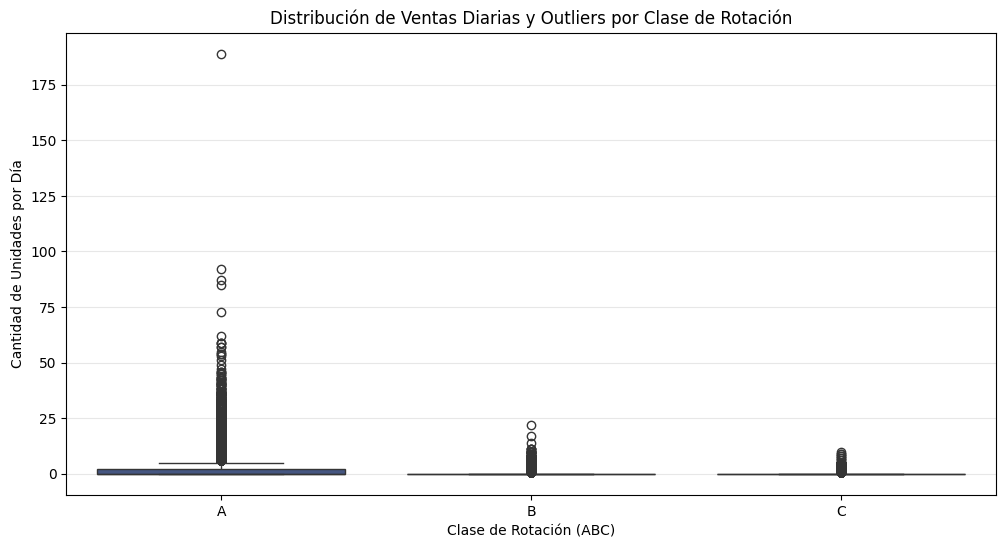

In [63]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=OutlierDF, x='ClasificacionABC', y='Cantidad', palette='viridis')
plt.title('Distribución de Ventas Diarias y Outliers por Clase de Rotación')
plt.ylabel('Cantidad de Unidades por Día')
plt.xlabel('Clase de Rotación (ABC)')
plt.grid(axis='y', alpha=0.3)
plt.show()

Se imputa el valor atipico en la Clase A para evitar que el modelo ajuste la curva a un dato no recurrente.

In [64]:
OutlierDF = OutlierDF.loc[OutlierDF['Cantidad'] <= 100]
OutlierDF.sort_values('Cantidad', ascending=False).head(10)

,ClasificacionABC,Categoria Producto,Fecha,Cantidad
24853,A,ferramentas_jardim,2017-11-24,92
8303,A,cama_mesa_banho,2017-11-25,87
33435,A,moveis_decoracao,2017-11-24,85
7076,A,beleza_saude,2017-11-24,73
43243,A,telefonia,2017-11-24,62
7689,A,brinquedos,2017-11-24,59
19949,A,esporte_lazer,2017-11-24,59
27305,A,informatica_acessorios,2017-11-24,59
38339,A,perfumaria,2017-11-24,57
40791,A,relogios_presentes,2017-11-24,57


/tmp/ipython-input-1122077693.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=OutlierDF, x='ClasificacionABC', y='Cantidad', palette='viridis')


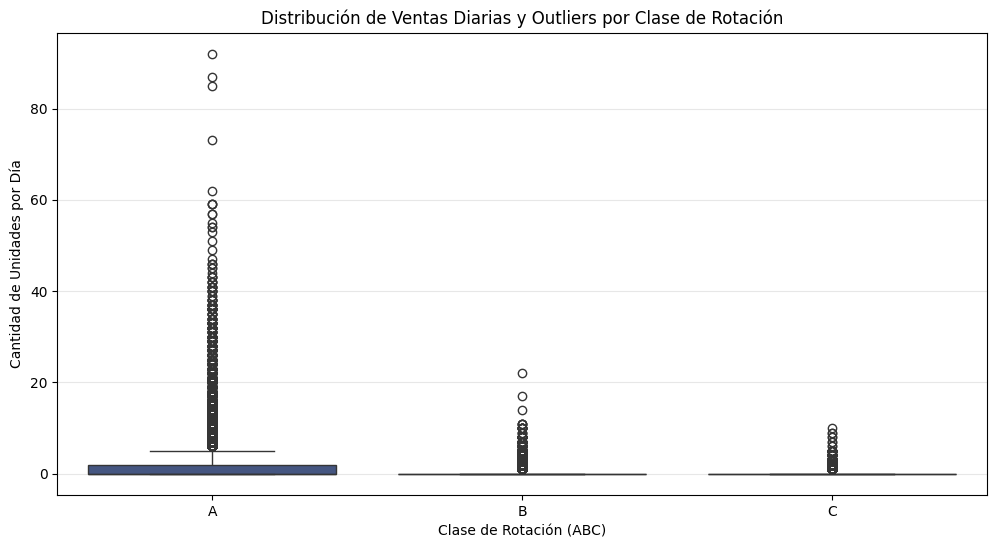

In [65]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=OutlierDF, x='ClasificacionABC', y='Cantidad', palette='viridis')
plt.title('Distribución de Ventas Diarias y Outliers por Clase de Rotación')
plt.ylabel('Cantidad de Unidades por Día')
plt.xlabel('Clase de Rotación (ABC)')
plt.grid(axis='y', alpha=0.3)
plt.show()

In [66]:
ClassA['Cantidad'].describe()

,Cantidad
count,82250.000000
mean,1.056231
std,0.304875
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,21.000000


In [67]:
ClassB['Cantidad'].describe()


,Cantidad
count,13177.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


In [68]:
ClassC['Cantidad'].describe()


,Cantidad
count,4317.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


In [69]:
#Analisis de Estacionalidad Visual
# Seleccionamos una categoría líder por cada clase
cats_representativas = OutlierDF.sort_values('Cantidad', ascending=False).groupby('ClasificacionABC')['Categoria Producto'].first().reset_index()['Categoria Producto'].tolist()
cats_representativas

/tmp/ipython-input-3680896575.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cats_representativas = OutlierDF.sort_values('Cantidad', ascending=False).groupby('ClasificacionABC')['Categoria Producto'].first().reset_index()['Categoria Producto'].tolist()


['ferramentas_jardim', 'cama_mesa_banho', 'cool_stuff']

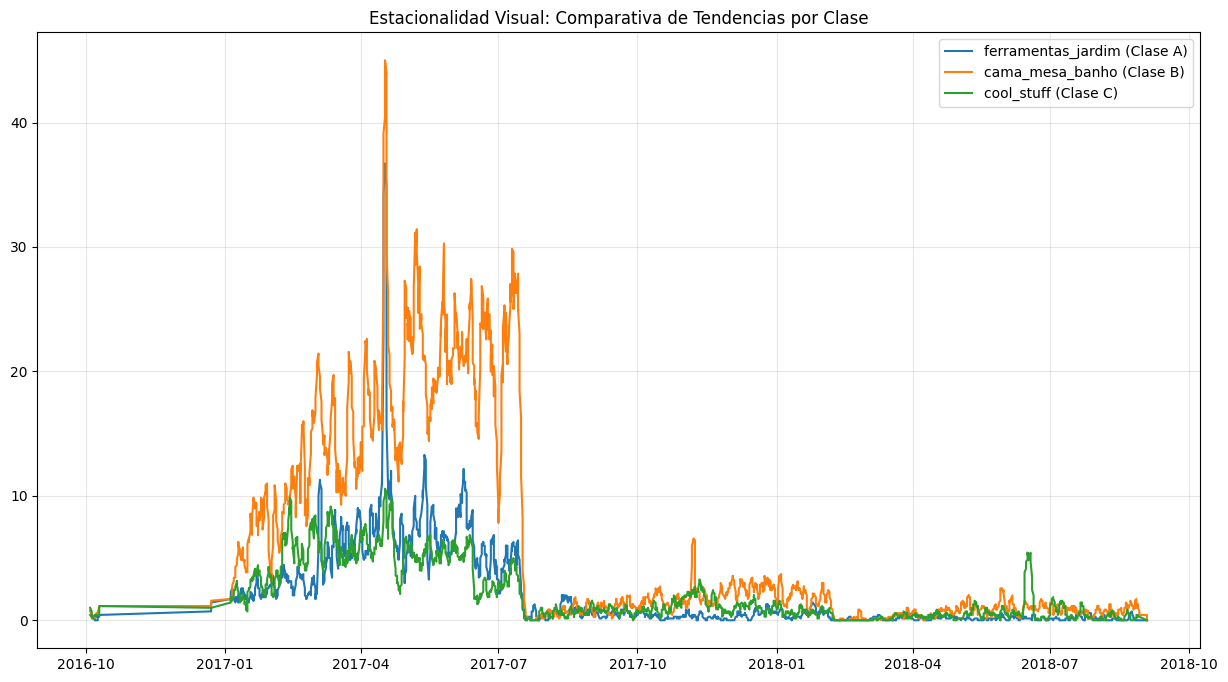

In [74]:
plt.figure(figsize=(15, 8))

Rt = ['A', 'B', 'C']
OutlierDF['Fecha'] = pd.to_datetime(OutlierDF['Fecha']) #Normalizacion de las Fechas para grafico de estacionalidad
for i, cat in enumerate(cats_representativas):
    subset = OutlierDF[OutlierDF['Categoria Producto'] == cat]
    # Aplicamos media móvil para limpiar el ruido y ver la "forma" de la estacionalidad
    plt.plot(subset['Fecha'].sort_values(), subset['Cantidad'].rolling(7).mean(), label=f"{cat} (Clase {Rt[i]})")

plt.title('Estacionalidad Visual: Comparativa de Tendencias por Clase')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Definimos las Variables Exogenas del Modelo
---

In [75]:
# A partir de la estacionalidad, tomamos en consideracion las fechas festivas Brasileras (Variable Exogena asociada a ds)

holidays = pd.DataFrame({
    'holiday': 'brazil',
    'ds': pd.to_datetime([
      '2017-02-28', '2018-02-13',  # Carnaval
      '2017-04-14', '2018-03-30',  # Viernes Santo
      '2017-09-07', '2018-09-07',  # Independencia
      '2017-10-12', '2018-10-12',  # Nuestra Sra. Aparecida
      '2017-11-02', '2018-11-02',  # Todos los Santos
      '2017-11-15', '2018-11-15',  # Proclamación República
      '2017-11-24', '2018-11-23',  # Black Friday
      '2017-12-25', '2018-12-25'   # Navidad

    ]),
    'lower_window' : -1,
    'upper_window': 1,
})

holidays

,holiday,ds,lower_window,upper_window
0,brazil,2017-02-28,-1,1
1,brazil,2018-02-13,-1,1
2,brazil,2017-04-14,-1,1
3,brazil,2018-03-30,-1,1
4,brazil,2017-09-07,-1,1
5,brazil,2018-09-07,-1,1
6,brazil,2017-10-12,-1,1
7,brazil,2018-10-12,-1,1
8,brazil,2017-11-02,-1,1
9,brazil,2018-11-02,-1,1


Para obtener una prediccion robusta y elocuente, seleccionamos las 10 categorias que tuvieron un % de dias con ventas alto (Densidad) y las ordenamos segun las cantidades vendidas por cada uno de los clasificadores de rotacion para la creacion de la funcion selectora de prediccion gerencial.

In [171]:
#Seleccion de Categorias con Calidad en Ventas
TopA = TopCatA['Categoria Producto'].head(15).tolist()
TopB = TopCatB['Categoria Producto'].head(10).tolist()
TopC = TopCatC['Categoria Producto'].head(5).tolist()

In [172]:
TopA

['moveis_decoracao',
 'esporte_lazer',
 'beleza_saude',
 'cama_mesa_banho',
 'informatica_acessorios',
 'telefonia',
 'utilidades_domesticas',
 'brinquedos',
 'cool_stuff',
 'automotivo',
 'ferramentas_jardim',
 'perfumaria',
 'relogios_presentes',
 'bebes']

In [173]:
# Reorganizacion del DataFrame de Clases por Categoria
A = ClassA[ClassA['Categoria Producto'].str.lower().isin(TopA)].sort_values('Fecha', ascending= False).groupby(['Categoria Producto', 'Fecha'])['Cantidad'].sum().reset_index()
A.columns = ['Categoria de Producto', 'ds', 'y']
A

,Categoria de Producto,ds,y
0,automotivo,2016-10-04,1
1,automotivo,2016-10-05,2
2,automotivo,2016-10-06,1
3,automotivo,2016-10-07,2
4,automotivo,2016-10-08,1
...,...,...,...
8115,utilidades_domesticas,2018-08-24,27
8116,utilidades_domesticas,2018-08-25,3
8117,utilidades_domesticas,2018-08-26,11
8118,utilidades_domesticas,2018-08-27,9


In [283]:
#Realizamos el Merge entre los DataFrame Reestructurados y las Variables Exogenas

calendarioA = pd.DataFrame({'ds': pd.date_range(start=A['ds'].min(), end=A['ds'].max(), freq='D')})

SeriesA = pd.merge(calendarioA, A, on='ds', how='left')
SeriesA['y'] = SeriesA['y'].fillna(0)
SeriesA['Categoria de Producto'] = SeriesA['Categoria de Producto'].ffill()
SeriesA



,ds,Categoria de Producto,y
0,2016-09-04,moveis_decoracao,3.0
1,2016-09-05,moveis_decoracao,0.0
2,2016-09-06,moveis_decoracao,0.0
3,2016-09-07,moveis_decoracao,0.0
4,2016-09-08,moveis_decoracao,0.0
...,...,...,...
8229,2018-08-28,utilidades_domesticas,7.0
8230,2018-08-29,beleza_saude,3.0
8231,2018-08-29,esporte_lazer,1.0
8232,2018-08-29,informatica_acessorios,1.0


In [277]:
def Cat_Selection(Series, Categoria):
  #Se filtra la categoria seleccionada en la serie
  SeriesCat = Series[Series['Categoria de Producto'] == Categoria].copy()
  SeriesCat['ds'] = pd.to_datetime(SeriesCat['ds'])

  #Aseguramos continuidad reindexando
  SeriesCat = SeriesCat.groupby('ds').agg({'y': 'sum'}).reset_index()
  rango = pd.date_range(start=SeriesCat['ds'].min(), end=SeriesCat['ds'].max(), freq='D')
  SeriesCat = SeriesCat.set_index('ds').reindex(rango).reset_index()
  SeriesCat.columns = ['ds', 'y']

  #Imputacion de Valores
  SeriesCat['y'] = SeriesCat['y'].fillna(0)
  Series['Categoria de Producto'] = Categoria


  return SeriesCat[['ds', 'y']]

In [253]:
ProphetA = pd.DataFrame(Cat_Selection(SeriesA, 'bebes'))
ProphetA

,ds,y
0,2016-10-04,4.0
1,2016-10-05,4.0
2,2016-10-06,2.0
3,2016-10-07,2.0
4,2016-10-08,2.0
...,...,...
689,2018-08-24,2.0
690,2018-08-25,1.0
691,2018-08-26,2.0
692,2018-08-27,0.0


## Entrenamiento del Modelo Prophet
---

In [177]:
from prophet import Prophet

model = Prophet(
    holidays=holidays,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.05
)

model.fit(ProphetA)
future15 = model.make_future_dataframe(periods=15, freq='D')
forecast15 = model.predict(future15)



INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [291]:
SeriesA['Categoria de Producto'].unique()

array(['moveis_decoracao'], dtype=object)

In [292]:
Predictions = []

for cat in TopA:
  SeriesA = pd.merge(calendarioA, A, on='ds', how='left')
  SeriesA['y'] = SeriesA['y'].fillna(0)
  SeriesA['Categoria de Producto'] = SeriesA['Categoria de Producto'].ffill()
  SeriesA
  ProphetA = pd.DataFrame(Cat_Selection(SeriesA, cat))
  model2 = Prophet(
    holidays=holidays,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.05
  )
  model2.fit(ProphetA)
  future15 = model2.make_future_dataframe(periods=15, freq='D')
  forecast15 = model2.predict(future15)
  Predictions.append(forecast15['yhat'].tail(15).sum())
  print(Predictions)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[np.float64(188.7804603964044)]


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[np.float64(188.7804603964044), np.float64(154.32964298076968)]


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[np.float64(188.7804603964044), np.float64(154.32964298076968), np.float64(361.39415364656566)]


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[np.float64(188.7804603964044), np.float64(154.32964298076968), np.float64(361.39415364656566), np.float64(330.81794917207696)]


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[np.float64(188.7804603964044), np.float64(154.32964298076968), np.float64(361.39415364656566), np.float64(330.81794917207696), np.float64(131.82866586769967)]


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[np.float64(188.7804603964044), np.float64(154.32964298076968), np.float64(361.39415364656566), np.float64(330.81794917207696), np.float64(131.82866586769967), np.float64(91.4588033645901)]


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[np.float64(188.7804603964044), np.float64(154.32964298076968), np.float64(361.39415364656566), np.float64(330.81794917207696), np.float64(131.82866586769967), np.float64(91.4588033645901), np.float64(240.38774263059238)]


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[np.float64(188.7804603964044), np.float64(154.32964298076968), np.float64(361.39415364656566), np.float64(330.81794917207696), np.float64(131.82866586769967), np.float64(91.4588033645901), np.float64(240.38774263059238), np.float64(58.756894646834226)]


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[np.float64(188.7804603964044), np.float64(154.32964298076968), np.float64(361.39415364656566), np.float64(330.81794917207696), np.float64(131.82866586769967), np.float64(91.4588033645901), np.float64(240.38774263059238), np.float64(58.756894646834226), np.float64(42.56342814362205)]


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[np.float64(188.7804603964044), np.float64(154.32964298076968), np.float64(361.39415364656566), np.float64(330.81794917207696), np.float64(131.82866586769967), np.float64(91.4588033645901), np.float64(240.38774263059238), np.float64(58.756894646834226), np.float64(42.56342814362205), np.float64(144.96231332849732)]


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[np.float64(188.7804603964044), np.float64(154.32964298076968), np.float64(361.39415364656566), np.float64(330.81794917207696), np.float64(131.82866586769967), np.float64(91.4588033645901), np.float64(240.38774263059238), np.float64(58.756894646834226), np.float64(42.56342814362205), np.float64(144.96231332849732), np.float64(66.33736345861486)]


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[np.float64(188.7804603964044), np.float64(154.32964298076968), np.float64(361.39415364656566), np.float64(330.81794917207696), np.float64(131.82866586769967), np.float64(91.4588033645901), np.float64(240.38774263059238), np.float64(58.756894646834226), np.float64(42.56342814362205), np.float64(144.96231332849732), np.float64(66.33736345861486), np.float64(94.26745839555558)]


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[np.float64(188.7804603964044), np.float64(154.32964298076968), np.float64(361.39415364656566), np.float64(330.81794917207696), np.float64(131.82866586769967), np.float64(91.4588033645901), np.float64(240.38774263059238), np.float64(58.756894646834226), np.float64(42.56342814362205), np.float64(144.96231332849732), np.float64(66.33736345861486), np.float64(94.26745839555558), np.float64(239.07879738324922)]
[np.float64(188.7804603964044), np.float64(154.32964298076968), np.float64(361.39415364656566), np.float64(330.81794917207696), np.float64(131.82866586769967), np.float64(91.4588033645901), np.float64(240.38774263059238), np.float64(58.756894646834226), np.float64(42.56342814362205), np.float64(144.96231332849732), np.float64(66.33736345861486), np.float64(94.26745839555558), np.float64(239.07879738324922), np.float64(92.49224653418669)]


In [293]:
len(Predictions)

14

In [105]:
forecast15['yhat'].tail(15).sum()

np.float64(92.49224653418669)

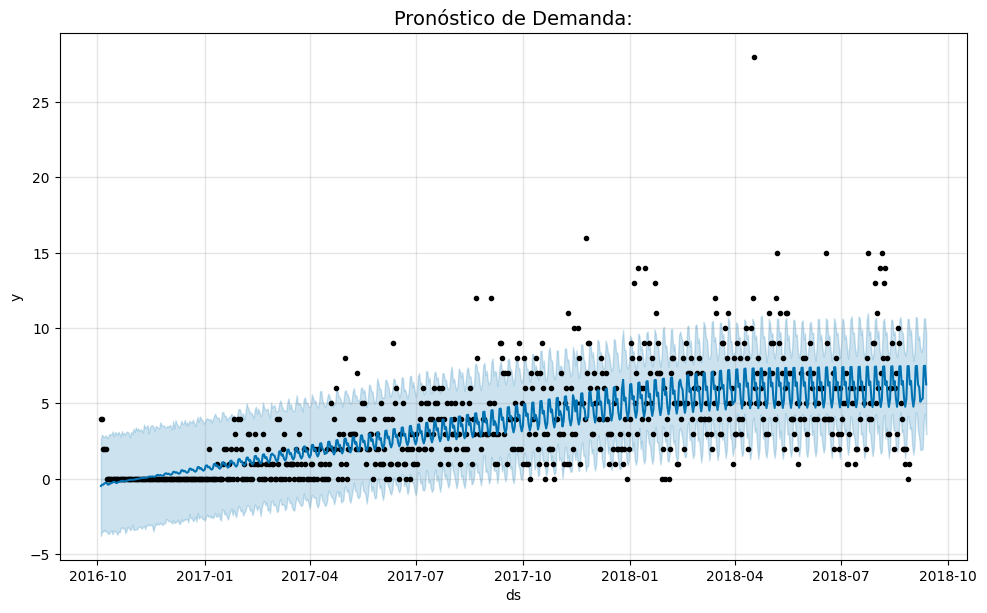

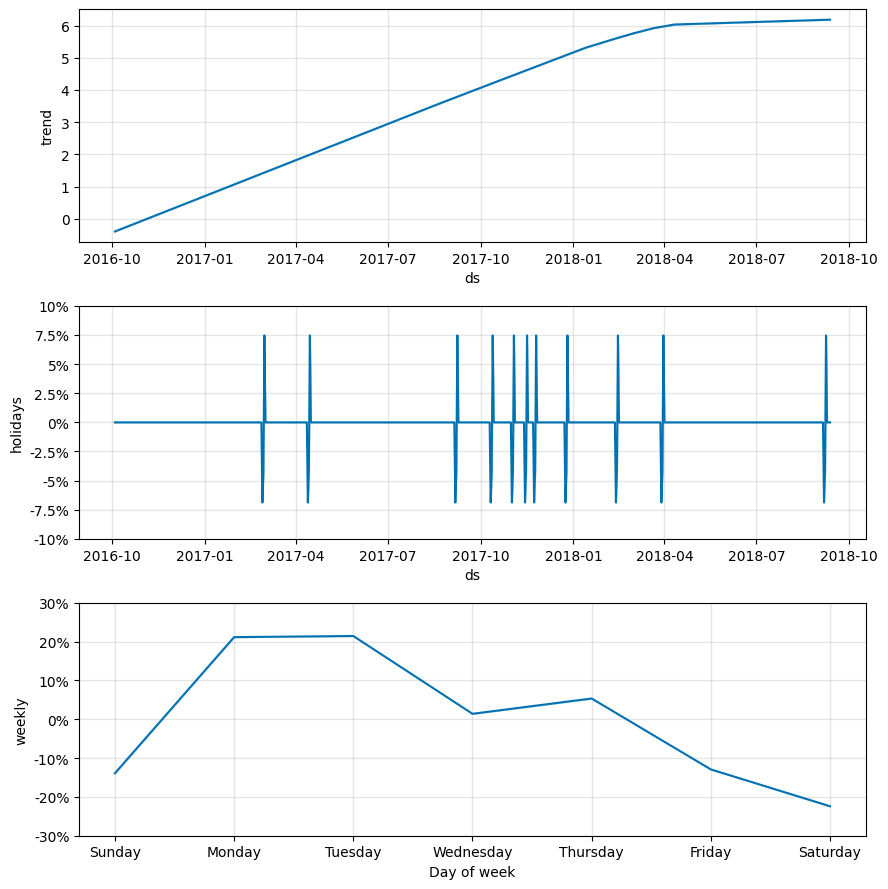

In [94]:
# Resultados del Modelo

# Gráfico Prediccion 15 dias
fig_pred = model.plot(forecast15)
plt.title(f"Pronóstico de Demanda de 15 Dias:", fontsize=14)
plt.show()

# Gráfico de componentes (Efecto de festivos y precio)
fig_comp = model.plot_components(forecast15)
plt.show()

In [229]:
from prophet.diagnostics import cross_validation, performance_metrics

#1. Realizamos Validacion Cruzada
df_cv = cross_validation(model, initial='540 days', horizon='20 days' , period= '15 days')

performance = performance_metrics(df_cv)
performance

INFO:prophet:Making 9 forecasts with cutoffs between 2018-04-10 00:00:00 and 2018-08-08 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,smape,coverage
0,2 days,7.583466,2.753809,2.198051,0.390008,0.392883,0.833333
1,3 days,6.371502,2.524183,2.239318,0.410607,0.423849,0.833333
2,4 days,6.545047,2.558329,2.139724,0.406538,0.428661,0.777778
3,5 days,9.669448,3.109574,2.731106,0.434952,0.494428,0.666667
4,6 days,9.941622,3.153034,2.730007,0.369543,0.420822,0.611111
5,7 days,31.042706,5.571598,3.302115,0.337839,0.408562,0.666667
6,8 days,30.828348,5.552328,3.329126,0.419881,0.442218,0.722222
7,9 days,8.117262,2.849081,2.255905,0.362498,0.333697,0.666667
8,10 days,9.174747,3.028984,2.191851,0.354165,0.311296,0.777778
9,11 days,10.882828,3.298913,2.500527,0.363970,0.365236,0.666667
